In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

# ML: Predicting Star Ratings

Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a dataset of venue popularities provided by Yelp.  The dataset contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. We will walk you through one way to build a machine-learning algorithm.

## Metric

Your model will be assessed based on the root mean squared error of the number of stars you predict.  

## Download and parse the incoming data

We start by downloading the dataset from Amazon S3:

In [7]:
!aws s3 cp s3://mmlc-data/yelp_train_academic_dataset_business.json.gz .

fatal error: Unable to locate credentials


Download the file from this AWS [link](https://s3.amazonaws.com/mmlc-data/yelp_train_academic_dataset_business.json.gz). This file is only a sample of the full data `yelp_train_academic_dataset_business.json`

The training data are a series of JSON objects, in a gzipped file. 

Python supports gzipped files natively: [gzip.open](https://docs.python.org/2/library/gzip.html) has the same interface as `open`, but handles `.gz` files automatically.

The built-in json package has a `loads()` function that converts a JSON string into a Python dictionary.  We could call that once for each row of the file. [ujson](http://docs.micropython.org/en/latest/library/ujson.html) has the same interface as the built-in `json` library, but is *substantially* faster (at the cost of non-robust handling of malformed json).  We will use that inside a list comprehension to get a list of dictionaries:

In [2]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f] # List comprehensions are much faster

In [3]:
print ('Total data points: {0}'.format(len(data)))

Total data points: 37938


In [4]:
print (data[10])

{'business_id': 'XrzTVrJAjs0yYLvhFI9vkQ', 'full_address': '5508 Broadhead St\nMc Farland, WI 53558', 'hours': {}, 'open': True, 'categories': ['Hotels & Travel', 'Bed & Breakfast', 'Event Planning & Services', 'Hotels'], 'city': 'Mc Farland', 'review_count': 9, 'name': 'Parsonage Bed & Breakfast the', 'neighborhoods': [], 'longitude': -89.285206, 'state': 'WI', 'stars': 5.0, 'latitude': 43.015931, 'attributes': {'Accepts Credit Cards': True, 'Wi-Fi': 'free', 'Price Range': 2}, 'type': 'business'}


In Scikit Learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features.  Let's get in this habit now, by creating a separate list of the ratings:

In [5]:
# Create star-rating list, consists of stars for each data-point
star_ratings = [row['stars'] for row in data]

In [6]:
print (star_ratings[0:5])

[3.5, 4.0, 4.0, 4.5, 4.0]


### Notes:
1. [Pandas](http://pandas.pydata.org/) is able to read JSON text directly.  Use the `read_json()` function with the `lines=True` keyword argument.  While the rest of this notebook will assume you are using a list of dictionaries, you can complete it with dataframes, if you so desire.  Some of the example code will need to be modified in this case.

2. There are obvious miscodings in the data.  There is no need to try to correct them.

## city_avg
The venues belong to different cities.  You can image that the ratings in some cities are probably higher than others.  We wish to build an estimator to make a prediction based on this, but first we need to work out the average rating for each city.  For this problem, create a list of tuples (city name, star rating), one for each city in the dataset.

A simple approach is to go through all of the dictionaries in our array, calculating the sum of the star ratings and the number of venues for each city.  At the end, we can just divide the stars by the count to get the average.

We could create a separate sum and count variable for each city, but that will get tedious quickly.  A better approach to to create a dictionary for each.  The key will be the city name, and the value the running sum or running count.

One slight annoyance of this approach is that we will have to test whether a key exists in the dictionary before adding to the running tally.  The collections module's `defaultdict` class works around this by providing default values for keys that haven't been used.  Thus, if we do

In [7]:
from collections import defaultdict
star_sum = defaultdict(int) # defaultdict allows us so we don't have to initialize
count = defaultdict(int)

we can increment any key of `stars` or `count` without first worrying whether the key exists.  We need to go through the `data` and `star_ratings` list together, which we can do with the `zip()` function.

In [8]:
for row, stars in zip(data, star_ratings):
    # increment the running sum in star_sum
    star_sum[row['city']] += stars
    # increment the running count in count
    count[row['city']] += 1

print (len(star_sum))

167


Now we can calculate the average ratings.  Again, a dictionary makes a good container.  (*N.B.* Watch out for Python2's integer division.  Make sure at least one of your values is a float to get floating point division.)

In [9]:
avg_stars = dict()
for city in star_sum:
    # calculate average star rating and store in avg_stars
    avg_stars[city] = star_sum[city]*1./count[city]

There should be 167 different cities:

In [10]:
assert len(avg_stars) == 167

## city_model
Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `.fit()` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `.predict()` method can look up the average rating for the city of each record it receives.

In [11]:
from sklearn import base
from collections import defaultdict

class CityEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        star_sum = defaultdict(int) # defaultdict allows us so we don't have to initialize
        count = defaultdict(int)
        for row, stars in zip(X, y):
            # increment the running sum in star_sum
            star_sum[row['city']] += stars
            # increment the running count in count
            count[row['city']] += 1
        
        # Compute the average
        for city in star_sum:
            # calculate average star rating and store in avg_stars
            self.avg_stars[city] = star_sum[city]*1./count[city]
        
        return self
    
    def predict(self, X):
        # The city not in X then predict the average it as average of all cities
        for row in X:
            if row['city'] not in self.avg_stars: 
                self.avg_stars[row['city']] = sum(self.avg_stars.values())/len(self.avg_stars)
                
        return [self.avg_stars[row['city']] for row in X]

Now we can create an instance of our estimator and train it.

In [12]:
city_est = CityEstimator()
city_est.fit(data, star_ratings)

CityEstimator()

And let's see if it works.

In [13]:
city_est.predict(data[:5])

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75]

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [14]:
city_est.predict([{'city': 'Timbuktu'}])

[3.7127593360958078]

## lat_long_model
You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Instead of writing a custom estimator, we'll use one of the built-in estimators in Scikit Learn.  Since these estimators won't know what to do with a list of dictionaries, we'll build a `ColumnSelectTransformer` that will return an array containing selected keys of our feature matrix.  While it is tempting to hard-code the latitude and longitude in here, this transformer will be more useful in the future if we write it to work on an arbitrary list of columns.

In [15]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        X_trans=[]
        
        for row in X:
            X_trans.append([row[col] for col in self.col_names])
        
        return X_trans

Let's test it on a single row, just as a sanity check:

In [16]:
cst = ColumnSelectTransformer(['latitude', 'longitude'])
assert (cst.fit_transform(data[:1])
        == [[data[0]['latitude'], data[0]['longitude']]])

Now, let's feed the output of the transformer in to a `sklearn.neighbors.KNeighborsRegressor`.  As a sanity check, we'll test it with the first 5 rows.  To truly judge the performance, we'd need to make a test/train split.

In [17]:
from sklearn.neighbors import KNeighborsRegressor

data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

array([ 4. ,  4.2,  4. ,  3.8,  4.2])

Instead of doing this by hand, let's make a pipeline.  Remember that a pipeline is made with a list of (name, transformer-or-estimator) tuples. 

In [18]:
from sklearn.pipeline import Pipeline

geo_est = Pipeline([
        # ColumnSelectTransformer
        ('columnselector',ColumnSelectTransformer(['latitude', 'longitude'])),
        # KNeighborsRegressor
        ('knn',knn)
    ])

This should work the same way.

In [19]:
geo_est.fit(data, star_ratings)
geo_est.predict(test_data)

array([ 4. ,  4.2,  4. ,  3.8,  4.2])

The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction.  There is no reason to believe that 5 is the optimum value.  Determine a better value of this hyperparameter.   There are several ways to do this:

1. Use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) to split your data in to a training set and a test set.  Score the performance on the test set.  After finding the best hyperparameter, retrain the model on the full data at that hyperparameter value.

2. Use [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) to return cross-validation scores on your data for various values of the hyperparameter.  Choose the best one, and retrain the model on the full data.

3. Use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to do the splitting, training, and grading automatically.  `GridSearchCV` takes an estimator and acts as an estimator.  You can either give it the `KNeighborsRegressor` directly and put it in a pipeline, or you can pass the whole pipeline into the `GridSearchCV`.  In the latter case, remember that the hyperparameter `param` of an estimator named `est` in a pipeline becomes a hyperparameter of the pipeline with name `est__param`.


In [21]:
# Here we use the pipeline model to build the workflow
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

data_train, data_test, stars_train, stars_test = train_test_split(data, star_ratings, test_size=0.2,random_state=13)

print ("pipeline:", [name for name, _ in geo_est.steps])

# Let's build the model by tunning hyperparameters
# When using pipelines, along with the grid search make sure you use keys as your "className__paramName"
param = {'knn__n_neighbors': np.arange(4, 10)} # "range" function in python 3 is a generator not iterator
# Or 
# param = {'knn__n_neighbors': list(range(4, 10))}

grid_geo_est = GridSearchCV(geo_est, param_grid=param)

print ("Performing grid search...")

grid_geo_est.fit(data_train,stars_train)

print (grid_geo_est.best_estimator_)   
print (grid_geo_est.best_params_)

pipeline: ['columnselector', 'knn']
Performing grid search...
Pipeline(steps=[('columnselector', ColumnSelectTransformer(col_names=['latitude', 'longitude'])), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='uniform'))])
{'knn__n_neighbors': 9}


Mean-square error for model is 0.8165569254898898


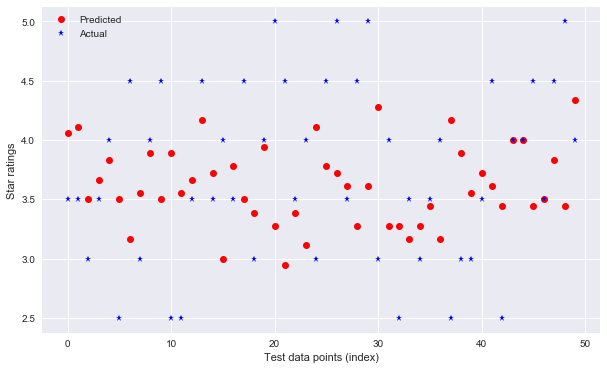

In [22]:
# Now predict on the test_data
import matplotlib.pyplot as plt

rating_prediction = grid_geo_est.predict(data_test)

def plot_rating(pred, ground_truth, n_samples=50):
    
    plt.figure(figsize=(10,6))
    plt.plot(pred[:n_samples], 'ro', linewidth=2)
    plt.plot(ground_truth[:n_samples], 'b*')
    plt.xlabel('Test data points (index)')
    plt.ylabel('Star ratings')
    plt.legend(['Predicted', 'Actual'])
    
    print ('Mean-square error for model is {0}'.format(mean_squared_error(pred, ground_truth)))
    
    return

plot_rating(rating_prediction, stars_test)


In [23]:
# Build a using Random forest regressor instead of KNN, to see if the score improves
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

geo_est_rfr = Pipeline([
    ('cst', cst),
    ('rfr', RandomForestRegressor())
    ])

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

param = {'rfr__n_estimators':list(range(10, 50, 5))}

geo_est_rfr_grid = GridSearchCV(geo_est_rfr, param_grid=param, scoring=mse_scorer)

print ("Performing grid search...")

geo_est_rfr_grid.fit(data_train,stars_train)

print (geo_est_rfr_grid.best_estimator_)   
print (geo_est_rfr_grid.best_params_)
# print (geo_est_rfr_grid.cv_results_)

Performing grid search...
Pipeline(steps=[('cst', ColumnSelectTransformer(col_names=['latitude', 'longitude'])), ('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=45, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])
{'rfr__n_estimators': 45}


Mean-square error for model is 0.8734479689660389


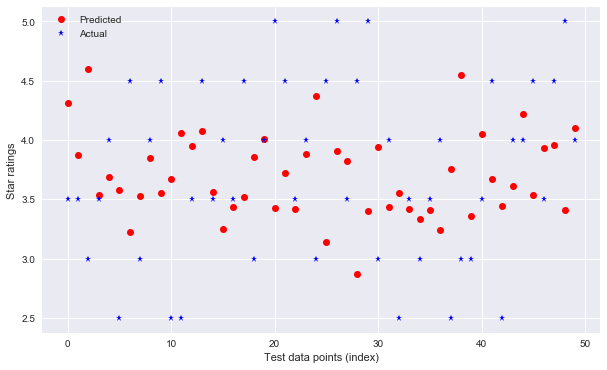

In [24]:
# Test the model
rating_prediction = geo_est_rfr_grid.predict(data_test)
# plot the prediction
plot_rating(rating_prediction, stars_test)


## category_model
While location is important, we could also try seeing how predictive the
venue's category is.  Build an estimator that considers only the categories.

The categories come as a list of strings, but the built-in estimators all need numeric input.  The standard way to deal with categorical features is **one-hot encoding**, also known as dummy variables.  In this approach, each category gets its own column in the feature matrix.  If the row has a given category, that column gets filled with a 1.  Otherwise, it is 0.

The `ColumnSelectTransformer` from the previous question can be used to extract the categories column as a list of strings.  Scikit Learn provides [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer), which takes in a list of dictionaries.  It creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it.  Missing keys are filled with zeros.  Therefore, we need only build a transformer that takes a list strings to a dictionary with keys given by those strings and values one.

In [25]:
cst = ColumnSelectTransformer(['categories'])
data_transform = cst.fit_transform(data_train)
print (len(data_transform))

30350


In [26]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.
                
        # X_encoded = [dict((k,1) for k in n) for l in X for n in l] # for python 2.x
        
        X_encoded = [{k: 1 for k in n} for l in X for n in l] # for python 3.x
        # print (X_encoded)
        return X_encoded

That should allow this to pass:

In [27]:
assert (DictEncoder().fit_transform([[['a']], [['b', 'c']]])
        == [{'a': 1}, {'b': 1, 'c': 1}])

Set up a pipeline with your `ColumnSelectTransformer`, your `DictEncoder`, the `DictVectorizer`, and a regularized linear model, like `Ridge`, as the estimator.  This model will have a large number of features, one for each category, so there is a significant danger of overfitting.  Use cross validation to choose the best regularization parameter.

In [28]:
# Now set up a pipeline
from sklearn.linear_model import RidgeCV
from sklearn.feature_extraction import DictVectorizer

category_pipe_model = Pipeline([('cst', ColumnSelectTransformer(['categories'])),
                          ('encoder', DictEncoder()),
                           ('vectorize', DictVectorizer(sparse=False)),      
                          ('ridgeCV', RidgeCV())
               ])

category_pipe_model.fit(data_train, stars_train)
#transformed_X = category_pipe_model.fit_transform(data_train)
#print (len(transformed_X), len(stars_train))

Pipeline(steps=[('cst', ColumnSelectTransformer(col_names=['categories'])), ('encoder', DictEncoder()), ('vectorize', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])

Mean-square error for model is 0.6562504634115657


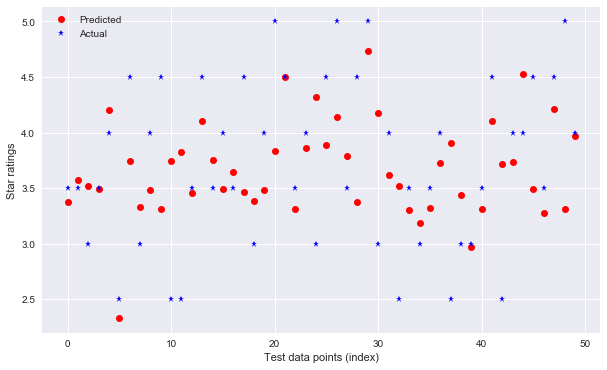

In [37]:
predicted_rating = category_pipe_model.predict(data_test)

plot_rating(predicted_rating, stars_test)

## attribute_model
There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them with one-hot encoding.  The `DictVectorizer` can do this, but only once we've flattened the dictionary to a single level, like so:
```
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```

Build a custom transformer that flattens the attributes dictionary.  Place this in a pipeline with a `DictVectorizer` and a (cross-validated) regularized linear model.

In [38]:
# Create an Transformer, that will flatten the attribute array
# cst = ColumnSelectTransformer(['attributes'])
# transformed_X = cst.fit_transform(data)
# print (transformed_X[:100])

In [33]:
# Create a Flatten transformer

class FlattenDictionary(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
       
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  
        X_encoded_flat = [self.flatten(j) for i in X for j in i] # For every dictionary element in X it returns a flattend array
             
        return X_encoded_flat
    
    def flatten(self, dict_item, lkey=''):
        # print (dict_item)
        dict_flat = {}
        for rkey, val in dict_item.items():
            key = lkey + rkey
            if isinstance(val, dict):
                dict_flat.update(self.flatten(val, key+'_')) # update will add the key to the dictionary
            else:
                if isinstance(val, bool):
                    dict_flat[key] = int(val)
                else: # This could be a string like "average", "causual" etc
                    dict_flat[key+'_'+str(val)] = 1 # Say that as True i.e, 1
        
        return dict_flat

In [34]:
# test_flat = FlattenDictionary()
# test_flat.fit(transformed_X)
# test_output = test_flat.fit_transform(transformed_X)

In [40]:
attributes_pipe_model = Pipeline([('cst', ColumnSelectTransformer(['attributes'])),
                          ('encoder', FlattenDictionary()),
                           ('vectorize', DictVectorizer(sparse=False)),      
                          ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10))
               ])

attributes_pipe_model.fit(data_train, stars_train)

Pipeline(steps=[('cst', ColumnSelectTransformer(col_names=['attributes'])), ('encoder', FlattenDictionary()), ('vectorize', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])

Mean-square error for model is 0.7347566724645319


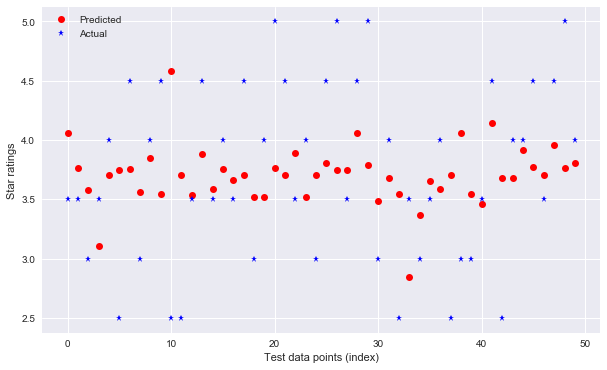

In [41]:
predicted_rating = attributes_pipe_model.predict(data_test)

plot_rating(predicted_rating, stars_test)

*Extension:* A common approach is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit.  Build a residual estimator that takes as an argument two other estimators.  It should use the first to fit the raw data and the second to fit the residuals of the first.  Can you improve performance with this setup?

## full_model
So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to an estimator, we will have to turn them into transformers.  (A pipeline can contain at most a single estimator.)  Build a custom `ModelTransformer` class that takes an estimator as an argument.  When `fit()` is called, the estimator should be fit.  When `transform()` is called, the estimator's `predict()` method should be called, and its results returned.

Note that the output of the `transform()` method should be a 2-D array with a single column, in order for it to work well with the Scikit Learn pipeline.  If you're using Numpy arrays, you can use `.reshape(-1, 1)` to create a column vector.  If you are just using Python lists, you will want a list of lists of single elements.

In [42]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        # What needs to be done here?
        self.estimator = estimator
    
    def fit(self, X, y):
        # Fit the stored estimator.
        self.estimator.fit(X, y)
        # Returning allows you to do method chaining
        return self # This is necessary outwise feature-union will not work
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # This should be a 2D array for union to work
        # X = np.array(X)
        # print (X)
        return np.array(self.estimator.predict(X)).reshape(-1,1)

This should work as follows:

In [43]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
# print (city_est.predict(data[:5]))
print (city_trans.transform(data[:5]).shape)
assert ([r[0] for r in city_trans.transform(data[:5])] == city_est.predict(data[:5]))

(5, 1)


Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [51]:
from sklearn.pipeline import FeatureUnion

feature_union = FeatureUnion([('city_mdl', EstimatorTransformer(city_est)), 
                              ('geo_mdl', EstimatorTransformer(grid_geo_est)),
                              ('category_mdl', EstimatorTransformer(category_pipe_model)), 
                              ('attributes_mdl', EstimatorTransformer(attributes_pipe_model))
                             ])
print (feature_union)

FeatureUnion(n_jobs=1,
       transformer_list=[('city_mdl', EstimatorTransformer(estimator=CityEstimator())), ('geo_mdl', EstimatorTransformer(estimator=GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('columnselector', ColumnSelectTransformer(col_names=['latitude', 'longitude'])), ('knn', KNeighbors..., fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])))],
       transformer_weights=None)


This should return a feature matrix with four columns.

In [53]:
transformed_data = feature_union.fit(data, star_ratings).transform(data)
#transformed_data = feature_union.transform(data)

print (transformed_data.shape)

(37938, 4)


Mean-square error for model is 0.5583939810517878


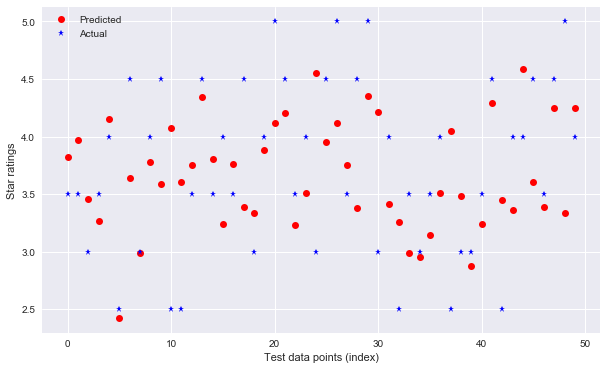

In [57]:
# print (transformed_data[:10])
# Now use the simple Linear regression of the tranformed data
from sklearn.linear_model import LinearRegression

data_train, data_test, stars_train, stars_test = train_test_split(transformed_data, star_ratings, 
                                                                  test_size=0.2,random_state=13)
full_model_lr = LinearRegression()

full_model_lr.fit(data_train, stars_train)
predictions_full_model = full_model_lr.predict(data_test)

plot_rating(predictions_full_model, stars_test)


Mean-square error for model is 0.6808817736187274


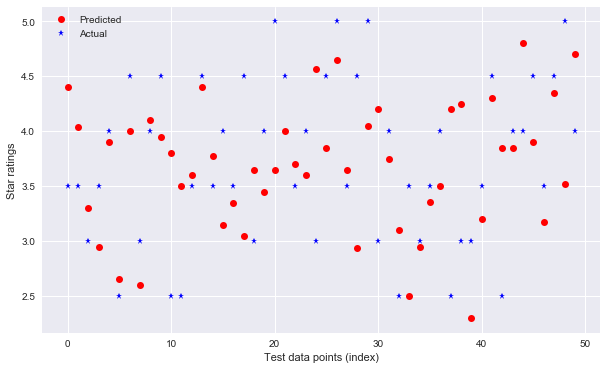

In [68]:
# We use random forest model
full_model_rfr = RandomForestRegressor()
full_model_rfr.fit(data_train, stars_train)

predictions_full_model_rfr = full_model_rfr.predict(data_test)
plot_rating(predictions_full_model_rfr, stars_test)

In the below code, I have used a normal way of combining the estimators (you can make an anology with feature union).

In [58]:
# Somehow feature union is not working :(
import pandas as pd

mdl_names = ['city_mdl', 'geo_mdl', 'category_mdl', 'attributes_mdl']
models = [city_est, grid_geo_est, category_pipe_model, attributes_pipe_model]
combined_features = pd.DataFrame(index = range(len(data)), columns=mdl_names)


for mdl, mdl_name in zip(models, mdl_names):
    
    trans_mdl = EstimatorTransformer(mdl)
    
    trans_mdl.fit(data, star_ratings)
    
    data_trans_mdl = trans_mdl.transform(data)
    combined_features[mdl_name] = data_trans_mdl

    


Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [59]:
print (combined_features.head())

   city_mdl   geo_mdl  category_mdl  attributes_mdl
0   3.67029  3.777778      3.381382        4.053414
1   3.75000  3.777778      3.379125        3.461948
2   3.75000  4.055556      3.299097        3.697445
3   3.75000  4.000000      3.232245        3.230599
4   3.75000  3.888889      3.313543        3.207687


In [60]:
# Now we can use linear regresssion to combine these models


lr_mdl = LinearRegression()
rfr_mdl = RandomForestRegressor()

data_train, data_test, stars_train, stars_test = train_test_split(combined_features, star_ratings, test_size=0.2,random_state=13)



In [61]:
lr_mdl.fit(data_train, stars_train)
rfr_mdl.fit(data_train, stars_train)
rating_predictions = lr_mdl.predict(data_test)


Mean-square error for model is 0.680135745064385


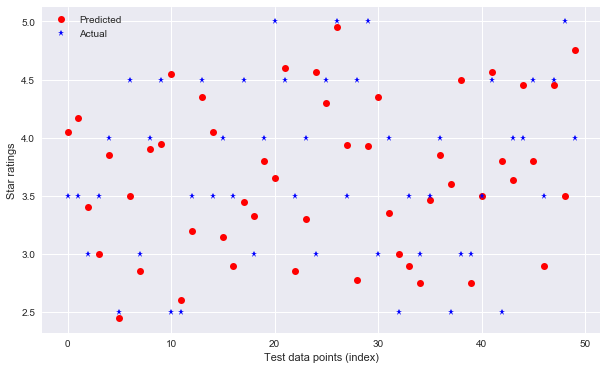

In [62]:
rating_predictions_rfr = rfr_mdl.predict(data_test)
plot_rating(rating_predictions_rfr, stars_test)

Mean-square error for model is 0.5583939810517863


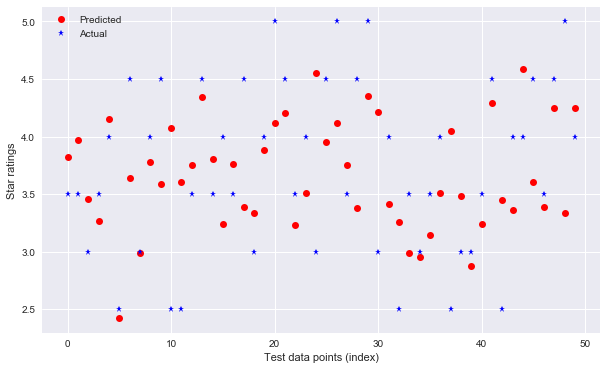

In [63]:
plot_rating(rating_predictions, stars_test)

*Extension:* By combining our models with a linear model, we will be unable to notice any correlation between features.  We don't expect all attributes to have the same effect on all venues.  For example, "Ambiance: divey" might be a bad indicator for a restaurant but a good one for a bar.  Nonlinear models can pick up on this interaction.  Replace the linear model combining the predictions with a nonlinear one like [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).  Better yet, use the nonlinear model to fit the residuals of the linear model.